## This experiment is to apply multiple algorithms and attain the best possible MAP@12 for the problem in hand.

### Approach 1

**Algorithm 1:** Find the most purchased article for each user, he/she is mostly will spent similar bucks in the same item or in some other article which is similar to that.  
This notebook will help us to get this algorithm up and running for each user. I will try to get the top 12 articles which are mostly assumed to be purchased by each user. If any user has purchased less than 12 articles, we will use top selling articles to complete article list till it reaches 12 in count. 

I will dump the submission csv for the entire dataset using this simple algorithm.

**Algorithm 2:** Use LightFM algorithm to find the relation among customer and articles which have seen no interaction in past however the customer may have a tendency to buy these unpurchased articles in future visits. This notebook is already trained and hyperparameters are also optimized based on reduced transaction dates. Store top 200 predictions for each user. Please find the link to these notebooks below:  

Link to Training Light FM model: https://www.kaggle.com/rickykonwar/h-m-lightfm-nofeatures  
Link to Hyper Parameter Tuning Light FM Model: https://www.kaggle.com/rickykonwar/h-m-lightfm-nofeatures-hyperparamter-tuning/notebook

### Approach 2  

**Algorithm 3 (Hybrid):** Once we have set the algorithm 1 and algorithm 2 inferencing outputs, I will form the top 200 recommended articles for each user by combining the most purchases any customer has made (based on algorithm 1) and remaining 200-N will be filled up based on inferencing outputs for the same customer (based on algorithm 2). This combined data will be the base for the hybrid algorithm. On top of these, we will add customer and articles metadata features to clse on the classifier model. 


## Importing Libraries

In [1]:
import os
import gc
import copy
import time
import tqdm
import pickle
import datetime
import numpy as np
import pandas as pd
import scipy.sparse as sparse

from multiprocessing import Pool
from IPython.display import FileLink
from sklearn.model_selection import train_test_split

## Utility Functions

In [2]:
def apk(actual, predicted, k=12):
    '''
    Function to get Average Precision at K
    '''
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0
    
    return score / min(len(actual), k)

def mapk(actual, predicted, k=12):
    '''
    Function to get Mean Average Precision at K
    '''
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

def create_chunk_indices(meta_df, chunk_idx, chunk_size):
    '''
    Function to generate chunks of data for multiprocessing
    '''
    start_idx = chunk_idx * chunk_size
    end_idx = start_idx + chunk_size
    meta_chunk = meta_df[start_idx:end_idx]
    print("start/end "+str(chunk_idx+1)+":" + str(start_idx) + "," + str(end_idx))
    print(len(meta_chunk))
    #chunk_idx in return value is used to sort the processed chunks back into original order,
    return (meta_chunk, chunk_idx)

## Data Loading

In [3]:
data_path = r'../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv'
customer_data_path = r'../input/h-and-m-personalized-fashion-recommendations/customers.csv'
article_data_path = r'../input/h-and-m-personalized-fashion-recommendations/articles.csv'
submission_data_path = r'../input/h-and-m-personalized-fashion-recommendations/sample_submission.csv'

In [4]:
# Data Extraction
def create_data(datapath, data_type=None):
    if data_type is None:
        df = pd.read_csv(datapath)
    elif data_type == 'transaction':
        df = pd.read_csv(datapath, dtype={'article_id': str}, parse_dates=['t_dat'])
    elif data_type == 'article':
        df = pd.read_csv(datapath, dtype={'article_id': str})
    return df

In [5]:
%%time

# Load all sales data (for 3 years starting from 2018 to 2020)
# ALso, article_id is treated as a string column otherwise it 
# would drop the leading zeros while reading the specific column values
transactions_data=create_data(data_path, data_type='transaction')
print(transactions_data.shape)

# # Unique Attributes
print(str(len(transactions_data['t_dat'].drop_duplicates())) + "-total No of unique transactions dates in data sheet")
print(str(len(transactions_data['customer_id'].drop_duplicates())) + "-total No of unique customers ids in data sheet")
print(str(len(transactions_data['article_id'].drop_duplicates())) + "-total No of unique article ids courses names in data sheet")
print(str(len(transactions_data['sales_channel_id'].drop_duplicates())) + "-total No of unique sales channels in data sheet")

(31788324, 5)
734-total No of unique transactions dates in data sheet
1362281-total No of unique customers ids in data sheet
104547-total No of unique article ids courses names in data sheet
2-total No of unique sales channels in data sheet
CPU times: user 50.3 s, sys: 7.89 s, total: 58.2 s
Wall time: 1min 26s


In [6]:
%%time

# Load all Customers
customer_data=create_data(customer_data_path)
print(customer_data.shape)

print(str(len(customer_data['customer_id'].drop_duplicates())) + "-total No of unique customers ids in customer data sheet")

(1371980, 7)
1371980-total No of unique customers ids in customer data sheet
CPU times: user 3.52 s, sys: 392 ms, total: 3.91 s
Wall time: 5.78 s


In [7]:
%%time

# Load all Articles
article_data=create_data(article_data_path, data_type='article')
print(article_data.shape)

print(str(len(article_data['article_id'].drop_duplicates())) + "-total No of unique article ids in article data sheet")

(105542, 25)
105542-total No of unique article ids in article data sheet
CPU times: user 677 ms, sys: 51.1 ms, total: 728 ms
Wall time: 1.04 s


In [8]:
%%time

# Load all submission samples data
submission_data=create_data(submission_data_path)
print(submission_data.shape)

print(str(len(submission_data['customer_id'].drop_duplicates())) + "-total No of unique customer ids in submission data sheet")

(1371980, 2)
1371980-total No of unique customer ids in submission data sheet
CPU times: user 2.91 s, sys: 316 ms, total: 3.22 s
Wall time: 5.2 s


## Capturing Seasonal Effect by Limiting the transaction date
Based on notebook with link: https://www.kaggle.com/tomooinubushi/folk-of-time-is-our-best-friend/notebook

In [9]:
transactions_data = transactions_data[transactions_data['t_dat'] > '2020-08-21']
transactions_data.shape

(1190911, 5)

## Splitting transaction data to training and validation set

In [10]:
train_start_date = transactions_data.t_dat.min()
split_date = transactions_data.t_dat.max() - datetime.timedelta(days = 7)
train_transaction_data = transactions_data[(transactions_data.t_dat <= split_date) & (transactions_data.t_dat >= train_start_date)].copy()
test_transaction_data = transactions_data[transactions_data.t_dat > split_date].copy()

print(train_transaction_data.shape)
print(test_transaction_data.shape)

(950600, 5)
(240311, 5)


In [11]:
train_transaction_data = train_transaction_data.groupby(['customer_id','article_id']).agg({'t_dat':'count'}).reset_index()
test_transaction_data = test_transaction_data.groupby(['customer_id','article_id']).agg({'t_dat':'count'}).reset_index()

train_transaction_data.rename({'t_dat': 't_count'}, axis=1, inplace=True)
test_transaction_data.rename({'t_dat': 't_count'}, axis=1, inplace=True)

## Algorithm 1: Extracting Topmost articles for each user based on number of purchase made

In [12]:
train_val_merge_transaction_data = train_transaction_data[train_transaction_data.article_id.isin(test_transaction_data.article_id.unique())] 
train_top_articles = train_val_merge_transaction_data.sort_values(['customer_id', 't_count'], ascending=False).groupby(['customer_id']).head(12)
test_top_articles = test_transaction_data.sort_values(['customer_id', 't_count'], ascending=False).groupby(['customer_id']).head(12)

# Overall highly sold articles
overall_top_articles = train_top_articles.groupby(['article_id'], as_index = False)['t_count'].sum().sort_values(['t_count'])['article_id'][-12:].values
overall_top_articles = overall_top_articles[::-1]

In [13]:
train_top_articles.head(10)

,customer_id,article_id,t_count
842892,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0689365050,1
842893,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0762846027,1
842894,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0794819001,1
842895,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0884081001,1
842886,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0557599022,1
842887,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0713997002,1
842888,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0720125039,1
842889,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0740922009,1
842890,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0791587007,1
842891,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0804992033,1


In [14]:
test_top_articles.head(10)

,customer_id,article_id,t_count
213727,fffef3b6b73545df065b521e19f64bf6fe93bfd450ab20...,0898573003,1
213725,fffd870c6324ad3bda24e4d6aeae221c199479086bfdfd...,0750423010,1
213726,fffd870c6324ad3bda24e4d6aeae221c199479086bfdfd...,0761269001,1
213722,fffae8eb3a282d8c43c77dd2ca0621703b71e90904dfde...,0865624003,2
213715,fffae8eb3a282d8c43c77dd2ca0621703b71e90904dfde...,0396135007,1
213716,fffae8eb3a282d8c43c77dd2ca0621703b71e90904dfde...,0715624050,1
213717,fffae8eb3a282d8c43c77dd2ca0621703b71e90904dfde...,0797892001,1
213718,fffae8eb3a282d8c43c77dd2ca0621703b71e90904dfde...,0817472003,1
213719,fffae8eb3a282d8c43c77dd2ca0621703b71e90904dfde...,0817472007,1
213720,fffae8eb3a282d8c43c77dd2ca0621703b71e90904dfde...,0826150004,1


In [15]:
overall_top_articles

array(['0751471001', '0706016001', '0915526001', '0751471043',
       '0918292001', '0915529003', '0898694001', '0448509014',
       '0863595006', '0896152002', '0850917001', '0915526002'],
      dtype=object)

### Evaluating this algorithm

In [16]:
%%time

def perform_cross_validation(): 
    preds, trues = [],[]
    for customer in tqdm.tqdm(train_top_articles.customer_id.unique(), desc='Evaluating Simple Algorithm'):

        predict_n_articles = train_top_articles[train_top_articles.customer_id.isin([customer])]['article_id'].values[:12]
        actual_n_articles = test_top_articles[test_top_articles.customer_id.isin([customer])]['article_id'].values[:12]

        if len(predict_n_articles) < 12:
            predict_n_articles = list(predict_n_articles[:len(predict_n_articles)]) + list(overall_top_articles[:12 - len(predict_n_articles)])

        preds.append(list(predict_n_articles))
        trues.append(list(actual_n_articles))
    return preds, trues

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


In [17]:
preds = []
trues = []

if os.path.exists(r'../input/hm-trained-models/hybrid_generic/hybrid_simplealgo_actuals.pkl') and os.path.exists(r'../input/hm-trained-models/hybrid_generic/hybrid_simplealgo_preds.pkl'):

    with open(r'../input/hm-trained-models/hybrid_generic/hybrid_simplealgo_actuals.pkl', 'rb') as input_file:
        trues = pickle.load(input_file)
    with open(r'../input/hm-trained-models/hybrid_generic/hybrid_simplealgo_preds.pkl', 'rb') as input_file:
        preds = pickle.load(input_file)
else:
    preds, trues = perform_cross_validation()

#### Screenshot for predictions and actuals extraction

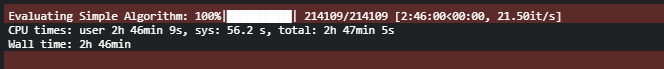

In [18]:
# Save Predictions and Actual
with open('hybrid_simplealgo_preds.pkl', 'wb') as f:
    pickle.dump(preds, f)
with open('hybrid_simplealgo_actuals.pkl', 'wb') as f:
    pickle.dump(trues, f)

In [19]:
score = np.round(mapk(trues, preds, k = 12), 5)
print(f'MAP@{12} = {score}')

MAP@12 = 0.006


### Getting Submission data from entire transaction data

In [20]:
purchase_dict = {}

for i,x in enumerate(zip(transactions_data['customer_id'], transactions_data['article_id'])):
    cust_id, art_id = x
    if cust_id not in purchase_dict:
        purchase_dict[cust_id] = {}
    
    if art_id not in purchase_dict[cust_id]:
        purchase_dict[cust_id][art_id] = 0
    
    purchase_dict[cust_id][art_id] += 1
    
print(len(purchase_dict))

256355


In [21]:
final_submission_data = submission_data[['customer_id']].copy()
prediction_list = []
top_articles_list = list((transactions_data['article_id'].value_counts()).index)[:12]
top_prediction_string = ' '.join(top_articles_list)

for i, cust_id in enumerate(submission_data['customer_id'].values.reshape((-1,))):
    if cust_id in purchase_dict:
        l = sorted((purchase_dict[cust_id]).items(), key=lambda x: x[1], reverse=True)
        l = [y[0] for y in l]
        if len(l)>12:
            s = ' '.join(l[:12])
        else:
            s = ' '.join(l+top_articles_list[:(12-len(l))])
    else:
        s = top_prediction_string
    prediction_list.append(s)

final_submission_data['prediction'] = prediction_list
print(final_submission_data.shape)

(1371980, 2)


In [22]:
final_submission_data.head()

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043 0751471001 0915529003 0915526001 09...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0751471001 0915529003 0915526001 0918292001 07...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0751471001 0915529003 0915526001 09...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0751471001 0915529003 0915526001 0918292001 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0751471001 0915529003 0915526001 0918292001 07...


### Writing Algo 1 Submissions

In [23]:
final_submission_data.to_csv("hybrid_algo1_submission.csv", index=False)
del final_submission_data
gc.collect()

0

In [24]:
FileLink(r'hybrid_algo1_submission.csv')

/kaggle/working/hybrid_algo1_submission.csv

## Algorithm 2: Load already trained lightfm model and predict top 200 articles for each user in submission data

In [25]:
lightfm_model_path = r'../input/hm-trained-models/lightfm_nofeatures/model_without_feature_optimized_01.pickle'
lightfm_model = pickle.load(open(lightfm_model_path, 'rb'))

In [26]:
class recommendation_sampling():
    def __init__(self, model, items = None, user_to_product_interaction_matrix = None, 
                item_features = None, user2index_map = None):
        
        self.user_to_product_interaction_matrix = user_to_product_interaction_matrix
        self.item_features = item_features if item_features is not None else None
        self.model = model
        self.items = items
        self.user2index_map = user2index_map
        
    def get_batched_recommendation(self, user, k=3, prediction_type='normal'):
        # Getting user_indexes 
        user_index = self.user2index_map.get(user, None)
        if user_index is None:
            return None
        
        # Scores from model
        scores = self.model.predict(user_ids = user_index, item_ids = np.arange(self.user_to_product_interaction_matrix.shape[1])) if prediction_type == 'normal' else \
            self.model.predict(user_ids = user_index, item_ids = np.arange(self.user_to_product_interaction_matrix.shape[1]), item_features = self.item_features)
    
        # Top items
        top_items = self.items[np.argsort(-scores)][:k]
        top_scores = np.sort(-scores)[::-1][:k]
        
        return top_items, top_scores
    
    def get_batched_recommendation_df(self, user, k=3, prediction_type='normal'):
        # Getting user_indexes 
        user_index = self.user2index_map.get(user, None)
        if user_index is None:
            return None
        
        # Scores from model
        scores = self.model.predict(user_ids = user_index, item_ids = np.arange(self.user_to_product_interaction_matrix.shape[1])) if prediction_type == 'normal' else \
            self.model.predict(user_ids = user_index, item_ids = np.arange(self.user_to_product_interaction_matrix.shape[1]), item_features = self.item_features)
    
        return scores

def get_customers_list():
    # Creating a list of users
    # return np.sort(transactions_data['customer_id'].unique()) TEMP_COMMENT
    return np.sort(customer_data['customer_id'].unique())

def get_articles_list():
    # Creating a list of courses 
    # item_list = transactions_data['article_id'].unique() TEMP_COMMENT
    item_list = article_data['article_id'].unique()
    return item_list

def id_mappings(customers_list, articles_list):
    """
    
    Create id mappings to convert user_id, item_id, and feature_id
    
    """
    customer_to_index_mapping = {}
    index_to_customer_mapping = {}
    for customer_index, customer_id in enumerate(customers_list):
        customer_to_index_mapping[customer_id] = customer_index
        index_to_customer_mapping[customer_index] = customer_id
        
    article_to_index_mapping = {}
    index_to_article_mapping = {}
    for article_index, article_id in enumerate(articles_list):
        article_to_index_mapping[article_id] = article_index
        index_to_article_mapping[article_index] = article_id
        
    return customer_to_index_mapping, index_to_customer_mapping, \
           article_to_index_mapping, index_to_article_mapping

def get_customer_article_interaction(customer_article_amt_df):
    #start indexing
    customer_article_amt_df["customer_id"] = customer_article_amt_df["customer_id"]
    customer_article_amt_df["article_id"] = customer_article_amt_df["article_id"]
    customer_article_amt_df["price"] = customer_article_amt_df["price"]

    # Preprocessing dataframe created
    customer_article_amt_df = customer_article_amt_df.rename(columns = {"price":"total_amount_spent"})

    # Replace Amount Column with category codes 
    customer_article_amt_df['total_amount_spent'] = customer_article_amt_df['total_amount_spent'].astype('category')
    customer_article_amt_df['total_amount_spent'] = customer_article_amt_df['total_amount_spent'].cat.codes

    return customer_article_amt_df

def get_interaction_matrix(df, df_column_as_row, df_column_as_col, 
                        df_column_as_value, row_indexing_map, col_indexing_map):
    
    row = df[df_column_as_row].apply(lambda x: row_indexing_map[x]).values
    col = df[df_column_as_col].apply(lambda x: col_indexing_map[x]).values
    value = df[df_column_as_value].values
    
    return sparse.coo_matrix((value, (row, col)), shape = (len(row_indexing_map), len(col_indexing_map)))

In [27]:
customers = get_customers_list()
articles = get_articles_list()
customer_to_index_mapping, index_to_customer_mapping, \
article_to_index_mapping, index_to_article_mapping = id_mappings(customers, articles)

In [28]:
transactions_data_grouped = transactions_data.groupby(['customer_id','article_id']).agg({'price':'sum','t_dat':'count'}).reset_index()
transactions_data_grouped = transactions_data_grouped[['customer_id','article_id','price']]

In [29]:
customer_to_article = get_customer_article_interaction(customer_article_amt_df = transactions_data_grouped[['customer_id','article_id','price']])
customer_to_article_interaction = get_interaction_matrix(customer_to_article, "customer_id", "article_id", "total_amount_spent", \
                                                        customer_to_index_mapping, article_to_index_mapping)            

In [30]:
customer_to_article.head()

,customer_id,article_id,total_amount_spent
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043,4205
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007,4791
2,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,0448509014,3443
3,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,0719530003,2792
4,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,0516859008,939


In [31]:
customer_to_article_interaction

<1371980x105542 sparse matrix of type '<class 'numpy.int16'>'
	with 1051730 stored elements in COOrdinate format>

In [32]:
# Sampling Recommendations
recom_without_feature = recommendation_sampling(model = lightfm_model,
                                               items = articles,
                                               user_to_product_interaction_matrix = customer_to_article_interaction,
                                               user2index_map = customer_to_index_mapping)

In [33]:
# Light FM Important Params
n_top = 200
lightfm_predictions_dict = {}
lightfm_predictions_df = pd.DataFrame()
predictions_with_df = False

In [34]:
def predict_top_articles(chunk):
    lightfm_predictions_dict = {}
    
    for row in tqdm.tqdm(chunk[0].values, desc='Predicting top 200 articles for each user'):
        customer = row[0]
        top_articles, top_scores = recom_without_feature.get_batched_recommendation(user=customer, k=200)
        lightfm_predictions_dict[customer] = {'top_200_articles': ' '.join(map(str, top_articles)),
                                              'top_200_scores': ' '.join(map(str, top_scores))} 
       
    return lightfm_predictions_dict

In [35]:
num_cores=4

def predict_top_articles_df(chunk_submission_data=None):
    lightfm_predictions_df = pd.DataFrame()
    
    for customer in tqdm.tqdm(chunk_submission_data['customer_id'].unique(), desc='Predicting top 200 articles for each user'):

        articles_df = pd.DataFrame(articles, columns = ['article_id'])
        articles_df['customer_id'] = customer
        articles_df['lightfm_score'] = recom_without_feature.get_batched_recommendation_df(customer, len(articles))
        articles_df.sort_values('lightfm_score', ascending = False, inplace = True)
        articles_df['lightfm_rank'] = np.arange(articles_df.shape[0])

        lightfm_predictions_df = lightfm_predictions_df.append(articles_df.head(n_top))
        
    return lightfm_predictions_df

def predict_top_200_articles(submission_data=None):
    #splitting here by measurement id's to get all signals for a measurement into single chunk
    customer_ids = submission_data["customer_id"].unique()
    df_split = np.array_split(customer_ids, num_cores)
    chunk_size = len(df_split[0])
    
    chunk1 = create_chunk_indices(submission_data, 0, chunk_size)
    chunk2 = create_chunk_indices(submission_data, 1, chunk_size)
    chunk3 = create_chunk_indices(submission_data, 2, chunk_size)
    chunk4 = create_chunk_indices(submission_data, 3, chunk_size)
    
    #list of items for multiprocessing, 4 since using 4 cores
    all_chunks = [chunk1, chunk2, chunk3, chunk4]
    
    pool = Pool(num_cores)
    result = pool.map(predict_top_articles, all_chunks)
    
    final_result_dict = copy.deepcopy(result[0])
    
    for item in result[1:]:
        final_result_dict.update(item)
    
    return final_result_dict

In [36]:
from numpy import save

customer_ids = submission_data["customer_id"].unique()
df_split = np.array_split(customer_ids, num_cores)
chunk_size = len(df_split[0])

chunk1 = create_chunk_indices(submission_data, 0, chunk_size)
chunk2 = create_chunk_indices(submission_data, 1, chunk_size)
chunk3 = create_chunk_indices(submission_data, 2, chunk_size)
chunk4 = create_chunk_indices(submission_data, 3, chunk_size)

# Getting top 200 articles for each user
if predictions_with_df:
    if os.path.exists(r'../input/hm-trained-models/hybrid_generic/top_200_articles_chunk_1.csv'):
        chunk1_top_200_article_data = pd.read_csv(r'../input/hm-trained-models/hybrid_generic/top_200_articles_chunk_1.csv')
    else:
        print('Inferencing for first chunk started')
        chunk1_top_200_article_data = predict_top_articles_df(chunk_submission_data = chunk1[0])
        chunk1_top_200_article_data.to_csv('top_200_articles_chunk_1.csv', index=False)
        FileLink(r'top_200_articles_chunk_1.csv')
        print('Inferencing for first chunk completed')
        
    if os.path.exists(r'../input/hm-trained-models/hybrid_generic/top_200_articles_chunk_2.csv'):
        chunk2_top_200_article_data = pd.read_csv(r'../input/hm-trained-models/hybrid_generic/top_200_articles_chunk_2.csv')
    else:
        print('Inferencing for second chunk started')
        chunk2_top_200_article_data = predict_top_articles_df(chunk_submission_data = chunk2[0])
        chunk2_top_200_article_data.to_csv('top_200_articles_chunk_2.csv', index=False)
        FileLink(r'top_200_articles_chunk_2.csv')
        print('Inferencing for second chunk completed')
        
    if os.path.exists(r'../input/hm-trained-models/hybrid_generic/top_200_articles_chunk_3.csv'):
        chunk3_top_200_article_data = pd.read_csv(r'../input/hm-trained-models/hybrid_generic/top_200_articles_chunk_3.csv')
    else:
        print('Inferencing for third chunk started')
        chunk3_top_200_article_data = predict_top_articles_df(chunk_submission_data = chunk3[0])
        chunk3_top_200_article_data.to_csv('top_200_articles_chunk_3.csv', index=False)
        FileLink(r'top_200_articles_chunk_3.csv')
        print('Inferencing for third chunk completed')
        
    if os.path.exists(r'../input/hm-trained-models/hybrid_generic/top_200_articles_chunk_4.csv'):
        chunk4_top_200_article_data = pd.read_csv(r'../input/hm-trained-models/hybrid_generic/top_200_articles_chunk_4.csv')
    else:
        print('Inferencing for fourth chunk started')
        chunk4_top_200_article_data = predict_top_articles_df(chunk_submission_data = chunk4[0])
        chunk4_top_200_article_data.to_csv('top_200_articles_chunk_4.csv', index=False)
        FileLink(r'top_200_articles_chunk_4.csv')
        print('Inferencing for fourth chunk completed')
    
    # top_200_articles_path = r'../input/hm-trained-models/hybrid_generic/top_200_articles.csv'
    # lightfm_predictions_df = pd.read_csv(top_200_articles_path) if os.path.exists(top_200_articles_path) else predict_top_articles_df()
else:
    if os.path.exists(r'../input/hm-trained-models/hybrid_generic/top_200_articles_chunk_1.pkl'):
        print('Reading for first chunk started')
        with open(r'../input/hm-trained-models/hybrid_generic/top_200_articles_chunk_1.pkl', 'rb') as input_file:
            chunk1_top_200_article_dict = pickle.load(input_file)
        print('Reading for first chunk completed')
    else:
        print('Inferencing for first chunk started')
        chunk1_top_200_article_dict = predict_top_articles(chunk1)
        with open('top_200_articles_chunk_1.pkl', 'wb') as f:
            pickle.dump(chunk1_top_200_article_dict, f)
        print('Inferencing for first chunk completed')
        
    if os.path.exists(r'../input/hm-trained-models/hybrid_generic/top_200_articles_chunk_2.pkl'):
        print('Reading for second chunk started')
        with open(r'../input/hm-trained-models/hybrid_generic/top_200_articles_chunk_2.pkl', 'rb') as input_file:
            chunk2_top_200_article_dict = pickle.load(input_file)
        print('Reading for second chunk completed')
    else:
        print('Inferencing for second chunk started')
        chunk2_top_200_article_dict = predict_top_articles(chunk2)
        with open('top_200_articles_chunk_2.pkl', 'wb') as f:
            pickle.dump(chunk2_top_200_article_dict, f)
        print('Inferencing for second chunk completed')
        
    if os.path.exists(r'../input/hm-trained-models/hybrid_generic/top_200_articles_chunk_3.pkl'):
        print('Reading for third chunk started')
        with open(r'../input/hm-trained-models/hybrid_generic/top_200_articles_chunk_3.pkl', 'rb') as input_file:
            chunk3_top_200_article_dict = pickle.load(input_file)
        print('Reading for third chunk completed')
    else:
        print('Inferencing for third chunk started')
        chunk3_top_200_article_dict = predict_top_articles(chunk3)
        with open('top_200_articles_chunk_3.pkl', 'wb') as f:
            pickle.dump(chunk3_top_200_article_dict, f)
        print('Inferencing for third chunk completed')
        
    if os.path.exists(r'../input/hm-trained-models/hybrid_generic/top_200_articles_chunk_4.pkl'):
        print('Reading for fourth chunk started')
        with open(r'../input/hm-trained-models/hybrid_generic/top_200_articles_chunk_4.pkl', 'rb') as input_file:
            chunk4_top_200_article_dict = pickle.load(input_file)
        print('Reading for fourth chunk completed')
    else:
        print('Inferencing for fourth chunk started')
        chunk4_top_200_article_dict = predict_top_articles(chunk4)
        with open('top_200_articles_chunk_4.pkl', 'wb') as f:
            pickle.dump(chunk4_top_200_article_dict, f)
        print('Inferencing for fourth chunk completed')
        
    # top_200_articles_dict_path = r'../input/hm-trained-models/hybrid_generic/top_200_articles.npy'
    # lightfm_predictions_dict = np.load(top_200_articles_dict_path) if os.path.exists(top_200_articles_dict_path) else predict_top_200_articles(submission_data)

start/end 1:0,342995
342995
start/end 2:342995,685990
342995
start/end 3:685990,1028985
342995
start/end 4:1028985,1371980
342995
Reading for first chunk started
Reading for first chunk completed
Reading for second chunk started
Reading for second chunk completed
Reading for third chunk started
Reading for third chunk completed
Reading for fourth chunk started
Reading for fourth chunk completed


#### Screenshot for chunk processing
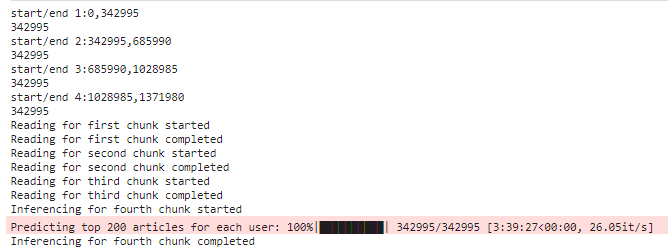

## Hybrid Data Compilation (Combining top N articles seen by each customer + (200-N) based on lightfm predictions for the same customer)

In [37]:
hybrid_params = {'top_n':200}

### Extract top selling articles based on transaction counts for each user

In [38]:
top_200_articles_list = list((transactions_data['article_id'].value_counts()).index)[:hybrid_params['top_n']]
top_200_prediction_string = ' '.join(top_200_articles_list)

### Fill up top N articles  
1. Based on transaction counts for known customers  
2. Fill up remaining (200-N) articles based on lightfm predictions fot these set of customers
3. Fill up top N articles for unseen customer based on overall top selling articles

In [39]:
def extract_lightfm_articles(customer_id, algo_1_article_list, algo_1_pred_no):
    lightfm_article, lightfm_score = None, None
    final_lightfm_article = []
    
    if customer_id in chunk1_top_200_article_dict.keys():
        lightfm_article, lightfm_score = chunk1_top_200_article_dict[customer_id]['top_200_articles'], chunk1_top_200_article_dict[customer_id]['top_200_scores']
        
    if customer_id in chunk2_top_200_article_dict.keys():
        lightfm_article, lightfm_score = chunk2_top_200_article_dict[customer_id]['top_200_articles'], chunk2_top_200_article_dict[customer_id]['top_200_scores']
        
    if customer_id in chunk3_top_200_article_dict.keys():
        lightfm_article, lightfm_score = chunk3_top_200_article_dict[customer_id]['top_200_articles'], chunk3_top_200_article_dict[customer_id]['top_200_scores']
        
    if customer_id in chunk4_top_200_article_dict.keys():
        lightfm_article, lightfm_score = chunk4_top_200_article_dict[customer_id]['top_200_articles'], chunk4_top_200_article_dict[customer_id]['top_200_scores']
        
    final_lightfm_article = list(set(lightfm_article.split(' ')) - set(algo_1_article_list))[:hybrid_params['top_n']-algo_1_pred_no]
    return final_lightfm_article

In [40]:
hybrid_submission_data = submission_data[['customer_id']].copy()
prediction_list = []

for i, cust_id in enumerate(hybrid_submission_data['customer_id'].values.reshape((-1,))):
    if cust_id in purchase_dict:
        l = sorted((purchase_dict[cust_id]).items(), key=lambda x: x[1], reverse=True)
        l = [y[0] for y in l]
        if len(l) > hybrid_params['top_n']:
            s = ' '.join(l[:hybrid_params['top_n']])
        else:
            s = ' '.join(l + extract_lightfm_articles(cust_id, l, len(l)))
    else:
        s = top_200_prediction_string
    prediction_list.append(s)

In [41]:
hybrid_submission_data['prediction'] = prediction_list
print(hybrid_submission_data.shape)
hybrid_submission_data.head()

(1371980, 2)


,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043 0779781006 0865076001 0783346020 08...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0751471001 0915529003 0915526001 0918292001 07...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0905957001 0915292001 0720125039 07...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0751471001 0915529003 0915526001 0918292001 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0751471001 0915529003 0915526001 0918292001 07...


### Writing Algo 1 + Algo 2 Submissions

In [42]:
hybrid_combined_submission = submission_data[['customer_id']].copy()
hybrid_combined_submission['prediction'] = hybrid_submission_data['prediction'].apply(lambda x: ' '.join(x.split(' ')[:12]))
hybrid_combined_submission.to_csv("hybrid_combined_submission.csv", index=False)
del hybrid_combined_submission
gc.collect()

126